'1.6.0'

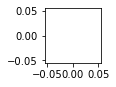

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [2]:
import aggets.ds.hyper_f_load as hyper_f_load
data = hyper_f_load.load()

In [3]:
import aggets.ds.aggregate_nd as agg_nd
cols = ['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9', 'att10']
train_np = agg_nd.as_np(data['train'], cols, 'class')
val_np = agg_nd.as_np(data['val'], cols, 'class')
test_np = agg_nd.as_np(data['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=500, e=0.00001, hist_bins=20, hist_dim=1)

ranges -> [[-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000080e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000070e+00]
 [-5.9999998e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]]


In [4]:
# window.init_structures()

In [11]:
import aggets.util as util
# util.save(window, path='nwindow_02.bin')
w = util.load(path='nwindow_01.bin') # 5 bins, 2 dim, 500ws
# w = util.load(path='nwindow_02.bin') # 20 bins, 1 dim, 500ws

In [12]:
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([1400, 5, 2, 45, 5, 5])
torch.Size([400, 5, 2, 45, 5, 5])
torch.Size([200, 5, 2, 45, 5, 5])
models
torch.Size([1400, 5, 11])
torch.Size([400, 5, 11])
torch.Size([200, 5, 11])

sets


[torch.Size([32, 10, 2, 45, 5, 5]), torch.Size([32, 5, 11])]

training model mlp
saving model MTL=0.05832571878212772, MVL=0.08780162403034786
saving model MTL=0.1701133782937102, MVL=0.06685365618221344
saving model MTL=0.09693877735774811, MVL=0.0621086320588513
saving model MTL=0.028343843763957828, MVL=0.061790572627196234
saving model MTL=0.02642460626690355, MVL=0.06168603104731393
saving model MTL=0.0234025181037242, MVL=0.060815057052033286
saving model MTL=0.021644339250341125, MVL=0.06021934493430077
saving model MTL=0.02043063318586513, MVL=0.0592496149714977
saving model MTL=0.019764139716721835, MVL=0.05849352443502063
saving model MTL=0.017965544291589086, MVL=0.05834793997189355
saving model MTL=0.017420589273208626, MVL=0.05768517552623673
saving model MTL=0.016700798177827984, MVL=0.05672709969064546
saving model MTL=0.015965159973937628, MVL=0.056212000962760716
saving model MTL=0.015202068732243423, MVL=0.055690504906196446
saving model MTL=0.014446492438719153, MVL=0.055627044053777816
saving model MTL=0.01456609375128463, MVL

<Figure size 432x288 with 0 Axes>

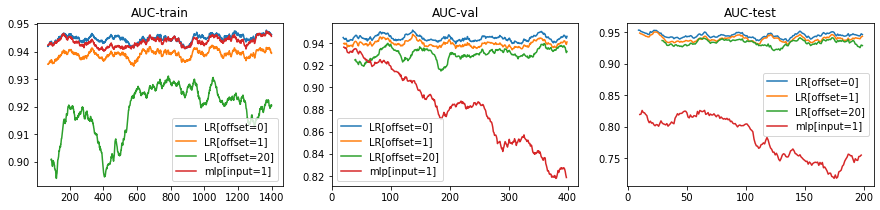

In [34]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# one step HIST -> LR
hidden = 256


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return x

class Reverse(nn.Module):
    def __init__(self):
        super(Reverse, self).__init__()

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, -1)
        return x

flatten = Flatten()
reverse = Reverse()
net = nn.Sequential(
    flatten,
    simple.mlp(features=2250, num_layers=4, out_features=11, hidden=hidden, input_dropout=0.1, dropout=0.4, 
               batch_norm=True),
    reverse
)
# out = simple.mlp(features=hidden, num_layers=1, out_features=11)

# -------
net.name = 'mlp'
net.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=1, label_stride=1)
train.train_window_models([net], w, patience=16, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg', target='lr', log=False, target_current_frame=True)
# -------
_, axs = plt.subplots(ncols=3, nrows=1,  figsize=(15, 3)) #sharey='row',
w.plot_lr(axs=axs)
w.plot_model(net, axs=axs, other={'source':'agg', 'target':'lr'})

training model mlp
saving model MTL=0.05644987315177645, MVL=0.08662610749403636
saving model MTL=0.18633431356111074, MVL=0.07231109719427806
saving model MTL=0.07895502898859107, MVL=0.06079636159397307


<Figure size 432x288 with 0 Axes>

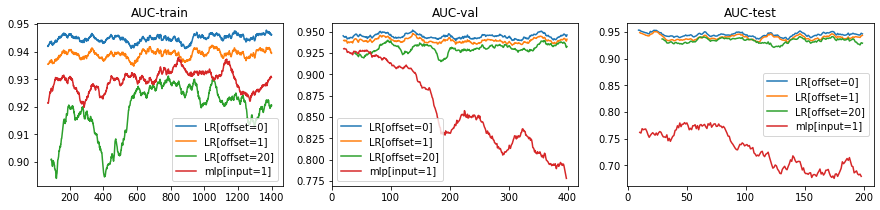

In [35]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# one step HIST -> LR
hidden = 256


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return x

class Reverse(nn.Module):
    def __init__(self):
        super(Reverse, self).__init__()

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, -1)
        return x

flatten = Flatten()
reverse = Reverse()
net = nn.Sequential(
    flatten,
    simple.mlp(features=2250, num_layers=4, out_features=11, hidden=hidden, input_dropout=0.1, dropout=0.4, 
               batch_norm=True),
    reverse
)
# out = simple.mlp(features=hidden, num_layers=1, out_features=11)

# -------
net.name = 'mlp'
net.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=1, label_stride=1)
train.train_window_models([net], w, patience=16, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg', target='lr', log=False, target_current_frame=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1,  figsize=(15, 3)) #sharey='row',
w.plot_lr(axs=axs)
w.plot_model(net, axs=axs, other={'source':'agg', 'target':'lr'})